In [32]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [34]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [35]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [36]:
# Sub-Problem 1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda=10.0, epsilon=1.0e-2, max_iter=100, draw_curve=False):
    # Get the number of samples (n) and features (m)
    n, m = X.shape

    # Initialize weight vector w and bias term w0
    w, w0 = Initialw(X, y)  # Function to initialize w and w0
    w = w.copy()  # Create a copy of w to avoid modifying the original

    # Precompute s_j = 2 * sum_{i} x_{ij}^2 for efficiency
    s = 2 * np.sum(X ** 2, axis=0)

    # Initialize a list to store objective values if plotting is required
    if draw_curve:
        obj_values = []

    # Start the coordinate descent algorithm
    for iteration in range(max_iter):
        w_old = w.copy()  # Store the old weights for convergence checking

        # Update each coordinate w_j
        for j in range(m):
            # Compute the residual without feature j
            r_j = y - (X @ w + w0) + X[:, j] * w[j]

            # Compute the numerator for the update step
            p_j = 2 * np.dot(X[:, j], r_j)

            # Update w_j based on the Lasso conditions
            if p_j < -lmda:
                w[j] = (p_j + lmda) / s[j]
            elif p_j > lmda:
                w[j] = (p_j - lmda) / s[j]
            else:
                w[j] = 0.0  # Shrinkage to zero if within the threshold

        # Update the bias term w0
        w0 = np.mean(y - X @ w)

        # Compute the maximum change in weights for convergence checking
        max_change = np.max(np.abs(w - w_old))

        # Compute the objective value if required for plotting
        if draw_curve:
            obj = 0.5 * np.sum((X @ w + w0 - y) ** 2) + lmda * np.sum(np.abs(w))
            obj_values.append(obj)

        # Check if the algorithm has converged
        if max_change <= epsilon:
            # Uncomment for debugging
            # print(f"Converged at iteration {iteration + 1}")
            break

    # Plot the objective value vs. iterations if required
    if draw_curve:
        plt.figure()
        plt.plot(obj_values)
        plt.xlabel('Iteration')
        plt.ylabel('Objective Value')
        plt.title('Objective Value vs. Iteration')
        plt.savefig('HW3_ex2_1')
        plt.show()

    return (w, w0)  # Return the final weights and bias


In [51]:
# Sub-Problem 1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

In [37]:
# Sub-Problem 1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

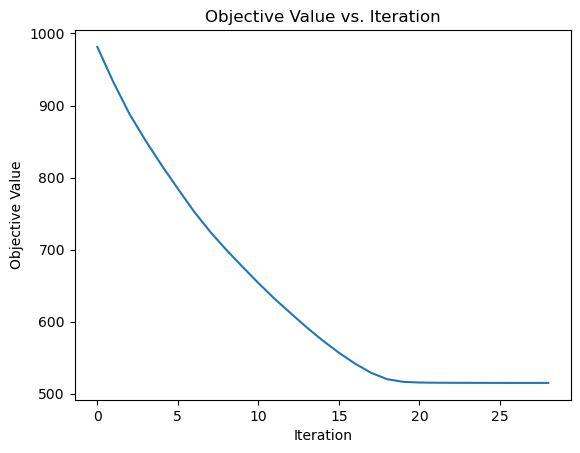

[ 9.90069222 -9.74699408 -9.76408978  9.98189982 10.07366017  0.
  0.          0.          0.          0.          0.         -0.04746542
  0.24981841  0.          0.0568768   0.          0.04728812  0.
  0.          0.          0.          0.          0.          0.
  0.         -0.03641103  0.          0.          0.          0.
  0.          0.          0.          0.          0.08410921  0.
 -0.04483507  0.          0.          0.          0.          0.06277042
  0.          0.          0.          0.          0.          0.
  0.02569664  0.          0.01223874  0.          0.19952606  0.
 -0.0240483   0.          0.          0.          0.          0.
  0.          0.          0.         -0.1421341   0.          0.
  0.          0.          0.          0.0684352   0.         -0.0408888
  0.          0.          0.        ]


In [38]:
# Sub-Problem 1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)

In [39]:
# Sub-Problem 2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    # Initialize variables for evaluation metrics
    rmse = 0.0
    sparsity_w = 0
    precision_w = 0.0
    recall_w = 0.0

    #########TODO##########
    # RMSE calculation
    y_pred = X @ w + w0
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))
    
    # Sparsity of w (number of non-zero entries)
    sparsity_w = np.count_nonzero(w)
    
    # Precision and recall
    nz_w = set(np.nonzero(w)[0])
    nz_w_true = set(np.nonzero(w_true)[0])
    true_positives = len(nz_w & nz_w_true)
    if len(nz_w) > 0:
        precision_w = true_positives / len(nz_w)
    else:
        precision_w = 0.0
        
    recall_w = true_positives / len(nz_w_true) if len(nz_w_true) > 0 else 0.0

    return (rmse, sparsity_w, precision_w, recall_w)  # Return the evaluation metrics


In [40]:
# Sub-Problem 2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)

# Unpack the evaluation metrics
rmse, sparsity_w, precision_w, recall_w = Emetric

# Print the results
print(f"RMSE: {rmse}")
print(f"Sparsity of w: {sparsity_w}")
print(f"Precision: {precision_w}")
print(f"Recall: {recall_w}")


RMSE: 0.5959848028774439
Sparsity of w: 20
Precision: 0.25
Recall: 1.0


In [41]:
# Sub-Problem 3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    # Compute lambda_max
    y_mean = np.mean(y)
    lambda_max = np.max(np.abs((y - y_mean) @ X))
    
    # Create lambda values
    Lmda = np.linspace(lambda_max, 0.0, num=50)
    n_lambda = len(Lmda)
    m = X.shape[1]
    
    # Initialize arrays to store the weights and intercepts
    W = np.zeros((m, n_lambda))
    W0 = np.zeros(n_lambda)
    
    # Compute lasso solution for each lambda
    for i, lmda in enumerate(Lmda):
        w_lasso, w0_lasso = lasso(X, y, lmda=lmda, epsilon=1.0e-2, max_iter=100)
        W[:, i] = w_lasso
        W0[i] = w0_lasso
    
    return (W, W0, Lmda)


In [42]:
# Sub-Problem 3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    n_lambda = len(Lmda)
    
    # Initialize arrays to store evaluation metrics
    RMSE = np.zeros(n_lambda)
    Sparsity = np.zeros(n_lambda)
    Precision = np.zeros(n_lambda)
    Recall = np.zeros(n_lambda)
    
    # Evaluate each solution for corresponding lambda
    for i in range(n_lambda):
        w = W[:, i]
        w0 = W0[i]
        
        # Get evaluation metrics using the Evaluate function
        rmse, sparsity_w, precision_w, recall_w = Evaluate(X, y, w, w0, w_true, w0_true)
        
        # Store the results
        RMSE[i] = rmse
        Sparsity[i] = sparsity_w
        Precision[i] = precision_w
        Recall[i] = recall_w
    
    return (RMSE, Sparsity, Precision, Recall)


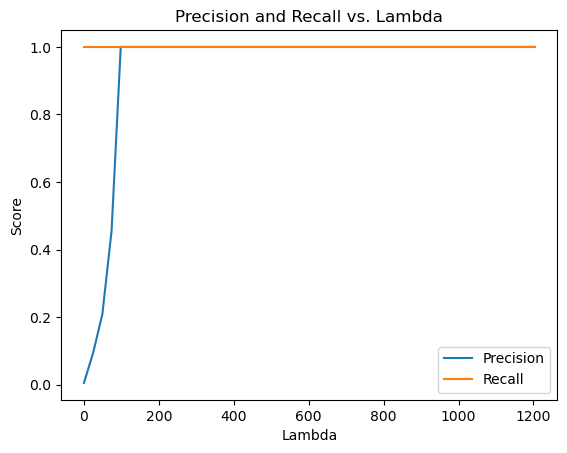

In [65]:
# Sub-Problem 3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=100, d=1000, k=5, sigma=1.0)

# Compute Lasso path
W, W0, Lmda = LassoPath(X, y)

# Evaluate the path
RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

# Plot Precision and Recall vs. Lambda
plt.figure()
plt.plot(Lmda, Precision, label='Precision')
plt.plot(Lmda, Recall, label='Recall')
plt.xlabel('Lambda')
plt.ylabel('Score')
plt.title(f'Precision and Recall vs. Lambda\nValue: {Lmda[-1]}, n: {len(Lmda)}')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Lambda')
plt.legend()
plt.savefig('HW3_ex2_3')
plt.show()


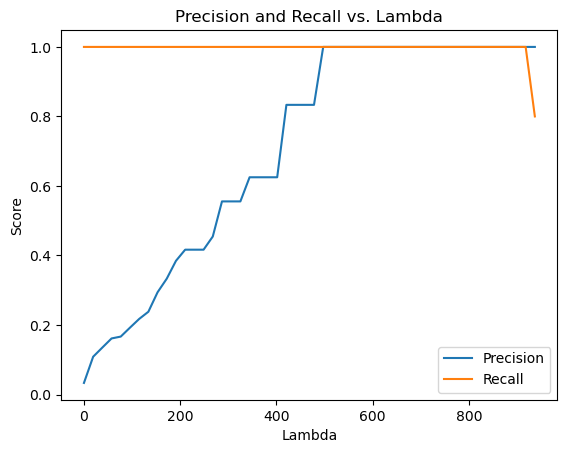

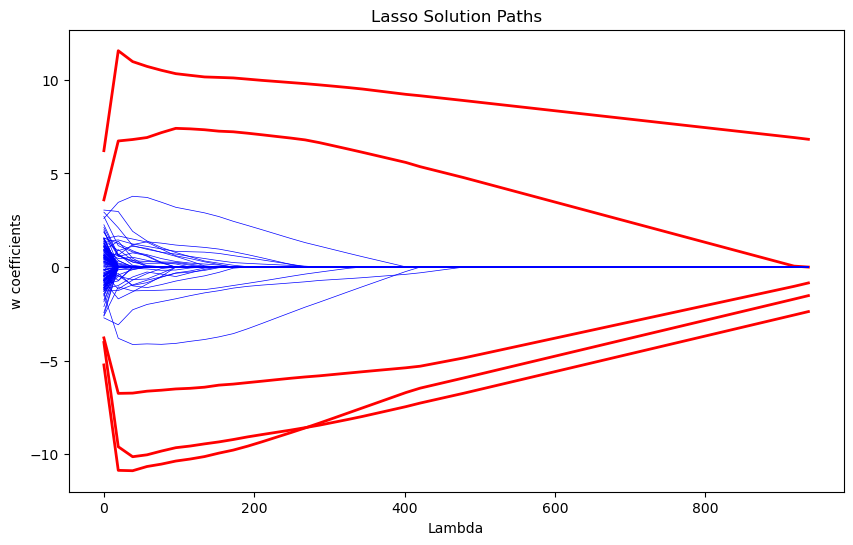

In [66]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)

# Compute Lasso path
W, W0, Lmda = LassoPath(X, y)

# Evaluate the path
RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

# Plot Precision and Recall vs. Lambda
plt.figure()
plt.plot(Lmda, Precision, label='Precision')
plt.plot(Lmda, Recall, label='Recall')
plt.xlabel('Lambda')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Lambda')
plt.legend()
plt.savefig('HW3_ex2_3')
plt.show()

# Plot Solution Paths
plt.figure(figsize=(10, 6))
for i in range(W.shape[0]):
    if i < 5:
        plt.plot(Lmda, W[i, :], color='red', linewidth=2)
    else:
        plt.plot(Lmda, W[i, :], color='blue', linewidth=0.5)
plt.xlabel('Lambda')
plt.ylabel('w coefficients')
plt.title('Lasso Solution Paths')
plt.savefig('HW3_ex2_3_2')
plt.show()


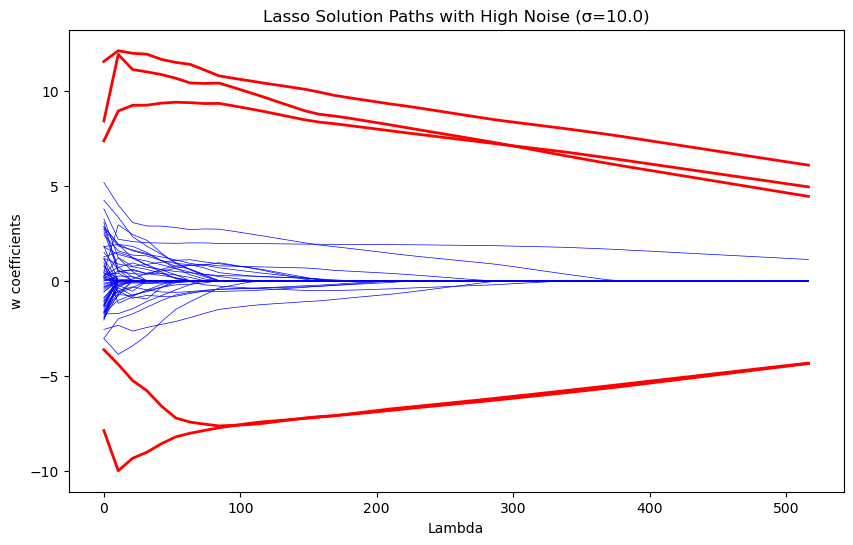

In [45]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
# (slightly changed the variable names to differentiate)

# Generate data with higher noise
X_high_noise, y_high_noise, w_true_high_noise, w0_true_high_noise = DataGenerator(n=50, d=75, k=5, sigma=10.0)

# Compute the Lasso path for the high noise data
W_high_noise, W0_high_noise, Lmda_high_noise = LassoPath(X_high_noise, y_high_noise)

# Evaluate the Lasso path
RMSE_high_noise, Sparsity_high_noise, Precision_high_noise, Recall_high_noise = EvaluatePath(
    X_high_noise, y_high_noise, W_high_noise, W0_high_noise, w_true_high_noise, w0_true_high_noise, Lmda_high_noise)

# Plot Solution Paths with High Sigma
plt.figure(figsize=(10, 6))
for i in range(W_high_noise.shape[0]):
    if i < 5:
        plt.plot(Lmda_high_noise, W_high_noise[i, :], color='red', linewidth=2)
    else:
        plt.plot(Lmda_high_noise, W_high_noise[i, :], color='blue', linewidth=0.5)
plt.xlabel('Lambda')
plt.ylabel('w coefficients')
plt.title('Lasso Solution Paths with High Noise (σ=10.0)')
plt.savefig('HW3_ex2_3_3')
plt.show()


In [69]:
# Sub-Problem 4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity

def run_and_plot_precision_recall():
    # cases = [
    #     (50, 150),
    #     (100, 200),
    #     (150, 300),
    #     (200, 400),
    #     (300, 600)
    # ]
    cases = [
        (50, 75),
        (50, 150),
        (50, 1000),
        (100, 75),
        (100, 150)
        (100, 1000)
    ]
   
    num_cases = len(cases)
    num_rows = 2
    num_cols = 3
    plt.figure(figsize=(18, 12))
    
    for idx, (n, d) in enumerate(cases):
        # Generate synthetic data
        X, y, w_true, w0_true = DataGenerator(n=n, d=d, k=5, sigma=1.0)
        
        # Compute Lasso path
        W, W0, Lmda = LassoPath(X, y)
        
        # Evaluate the path
        RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)
        
        # Plot Lasso Solution Paths
        plt.subplot(num_rows, num_cols, idx + 1)
        for i in range(W.shape[0]):
            if i < 5:
                plt.plot(Lmda, W[i, :], color='red', linewidth=1)
            else:
                plt.plot(Lmda, W[i, :], color='blue', linewidth=0.2)
        plt.xlabel('Lambda')
        plt.ylabel('w coefficients')
        plt.title(f'Lasso Paths (n={n}, d={d})')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    run_and_plot_precision_recall()


<>:18: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:18: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\faiez\AppData\Local\Temp\ipykernel_3384\1369935734.py:18: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (100, 150)


In [47]:
# Sub-Problem 5
# Adjusted lasso function for sparse data
def lasso_sparse(X, y, lmda=10.0, epsilon=1.0e-2, max_iter=100):
    n, m = X.shape
    # Initialize w and w0
    w, w0 = Initialw(X, y)
    w = w.copy()
    
    # Precompute s_j = sum_{i} x_ij^2
    s = X.power(2).sum(axis=0).A1  # .A1 converts to 1D NumPy array
    # For sparse X, store X in CSC format for efficient column access
    X_csc = X.tocsc()
    
    # Initialize residual
    y_pred = X.dot(w) + w0
    r = y - y_pred
    
    for iteration in range(max_iter):
        w_old = w.copy()
        for j in range(m):
            X_j = X_csc[:, j]
            # Compute p_j
            p_j = X_j.T.dot(r).item() + s[j] * w[j]
            # Update w_j
            if p_j < -lmda:
                w_j_new = (p_j + lmda) / s[j]
            elif p_j > lmda:
                w_j_new = (p_j - lmda) / s[j]
            else:
                w_j_new = 0.0
                
            delta_w_j = w_j_new - w[j]
            if delta_w_j != 0:
                w[j] = w_j_new
                # Update residual r only at non-zero positions of X_j
                r[X_j.indices] -= delta_w_j * X_j.data
                
        # Update w0
        w0 = np.mean(r + y_pred)
        y_pred = X.dot(w) + w0
        r = y - y_pred
        
        # Check convergence
        max_change = np.max(np.abs(w - w_old))
        if max_change <= epsilon:
            # print(f"Converged at iteration {iteration + 1}")
            break
            
    return (w, w0)


In [48]:
# Sub-Problem 5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int32)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

(30000, 2500) (30000,) (5000, 2500) (5000,) (10000, 2500) (10000,)
Processing lambda 1/20: 39.57825401364829
Processing lambda 2/20: 37.703494613001794
Processing lambda 3/20: 35.8287352123553
Processing lambda 4/20: 33.953975811708794
Processing lambda 5/20: 32.0792164110623
Processing lambda 6/20: 30.2044570104158
Processing lambda 7/20: 28.329697609769305
Processing lambda 8/20: 26.454938209122805
Processing lambda 9/20: 24.580178808476305
Processing lambda 10/20: 22.705419407829808
Processing lambda 11/20: 20.83066000718331
Processing lambda 12/20: 18.95590060653681
Processing lambda 13/20: 17.081141205890315
Processing lambda 14/20: 15.206381805243815
Processing lambda 15/20: 13.331622404597319
Processing lambda 16/20: 11.456863003950819
Processing lambda 17/20: 9.582103603304322
Processing lambda 18/20: 7.707344202657826
Processing lambda 19/20: 5.832584802011326
Processing lambda 20/20: 3.957825401364829


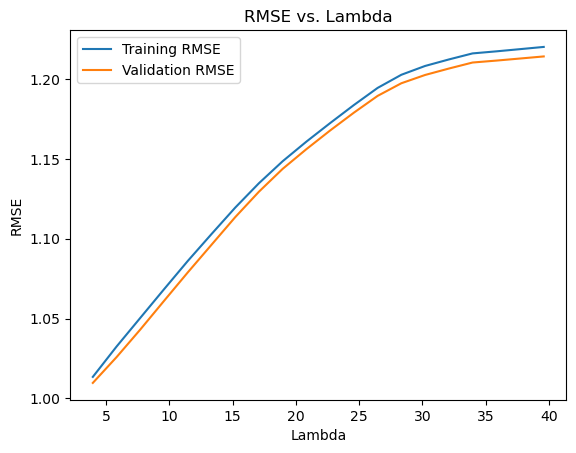

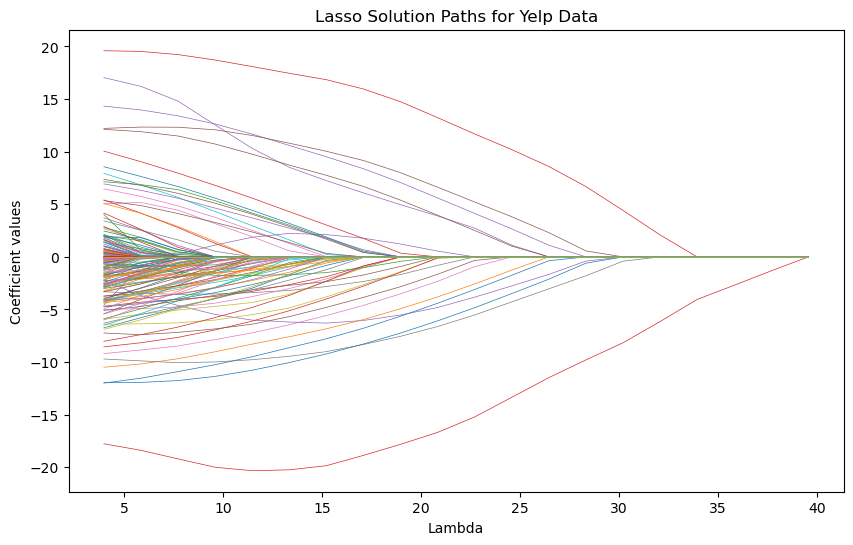

Best lambda: 3.957825401364829
Test RMSE: 1.025280261366466
Lasso selected features:
great 19.598078776217026
not -17.763132209890202
best 17.04152679088196
amazing 14.330230443457097
love 12.214923579194826
delicious 12.122804387860976
rude -11.99323257174512
the worst -11.960661968216113
horrible -10.489226717081712
awesome 10.05051759006501


In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Sub-Problem 5: predict reviews' star on Yelp
def Validation(X_train, y_train, X_valid, y_valid):
    # Compute lambda_max
    y_mean = np.mean(y_train)
    # Compute lambda_max using sparse matrix operations
    lambda_max_vec = X_train.T.dot(y_train - y_mean)
    lambda_max = np.max(np.abs(lambda_max_vec))
    
    # Create lambda values
    Lmda = np.linspace(lambda_max, lambda_max * 0.1, num=20)
    n_lambda = len(Lmda)
    m = X_train.shape[1]
    W = np.zeros((m, n_lambda))  # Coefficients for each lambda
    W0 = np.zeros(n_lambda)       # Intercept for each lambda
    train_RMSE = np.zeros(n_lambda)  # Training RMSE for each lambda
    valid_RMSE = np.zeros(n_lambda)  # Validation RMSE for each lambda
    
    for i, lmda in enumerate(Lmda):
        print(f"Processing lambda {i + 1}/{n_lambda}: {lmda}")
        
        # Perform Lasso regression (assume lasso_sparse is defined)
        w_lasso, w0_lasso = lasso_sparse(X_train, y_train, lmda=lmda, epsilon=1.0e-2, max_iter=100)
        
        # Store coefficients and intercept
        W[:, i] = w_lasso
        W0[i] = w0_lasso
        
        # Compute RMSE for training and validation
        y_train_pred = X_train.dot(w_lasso) + w0_lasso
        y_valid_pred = X_valid.dot(w_lasso) + w0_lasso
        train_RMSE[i] = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
        valid_RMSE[i] = np.sqrt(np.mean((y_valid - y_valid_pred) ** 2))
    
    # Find best lambda based on validation RMSE
    best_index = np.argmin(valid_RMSE)
    w_best = W[:, best_index]
    w0_best = W0[best_index]
    lmda_best = Lmda[best_index]
    
    # Plot RMSE vs. lambda
    plt.figure()
    plt.plot(Lmda, train_RMSE, label='Training RMSE')
    plt.plot(Lmda, valid_RMSE, label='Validation RMSE')
    plt.xlabel('Lambda')
    plt.ylabel('RMSE')
    plt.title('RMSE vs. Lambda')
    plt.legend()
    plt.savefig('HW3_ex2_5_1.png')  # Save the figure as a PNG file
    plt.show()
    
    # Plot Lasso solution paths
    plt.figure(figsize=(10, 6))
    for i in range(W.shape[0]):
        plt.plot(Lmda, W[i, :], linewidth=0.5)
    plt.xlabel('Lambda')
    plt.ylabel('Coefficient values')
    plt.title('Lasso Solution Paths for Yelp Data')
    plt.savefig('HW3_ex2_5_2.png')  # Save the figure as a PNG file
    plt.show()
    
    return (w_best, w0_best, lmda_best)

X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('hw3_data/data/star_data.mtx', 
'hw3_data/data/star_labels.txt', 
'hw3_data/data/star_features.txt', 
30000, 
5000)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

# Evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# Compute test RMSE
y_test_pred = X_test.dot(w_lasso) + w0_lasso
test_RMSE = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
print(f"Best lambda: {lmda_best}")
print(f"Test RMSE: {test_RMSE}")

# Print the top-10 features you found by Lasso
idx = (-np.abs(w_lasso)).argsort()[:10]
print('Lasso selected features:')
for i in range(10):
    print(fName[idx[i]], w_lasso[idx[i]])


(30000, 2500) (30000,) (5000, 2500) (5000,) (10000, 2500) (10000,)
Processing lambda 1/20: 39.57825401364829
Processing lambda 2/20: 37.703494613001794
Processing lambda 3/20: 35.8287352123553
Processing lambda 4/20: 33.953975811708794
Processing lambda 5/20: 32.0792164110623
Processing lambda 6/20: 30.2044570104158
Processing lambda 7/20: 28.329697609769305
Processing lambda 8/20: 26.454938209122805
Processing lambda 9/20: 24.580178808476305
Processing lambda 10/20: 22.705419407829808
Processing lambda 11/20: 20.83066000718331
Processing lambda 12/20: 18.95590060653681
Processing lambda 13/20: 17.081141205890315
Processing lambda 14/20: 15.206381805243815
Processing lambda 15/20: 13.331622404597319
Processing lambda 16/20: 11.456863003950819
Processing lambda 17/20: 9.582103603304322
Processing lambda 18/20: 7.707344202657826
Processing lambda 19/20: 5.832584802011326
Processing lambda 20/20: 3.957825401364829


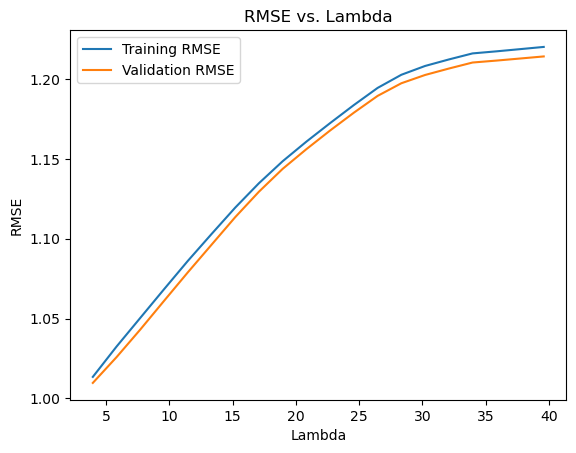

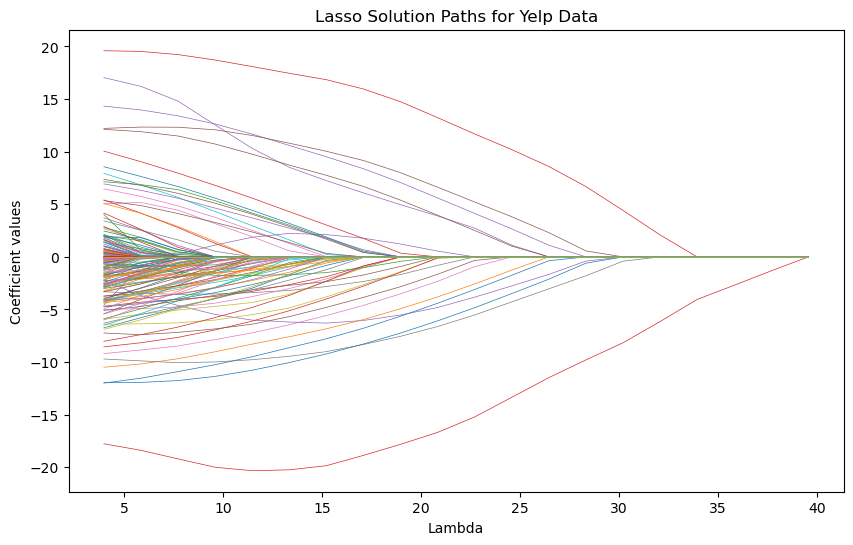

Best lambda: 3.957825401364829
Test RMSE: 1.025280261366466
Lasso selected features:
great 19.598078776217026
not -17.763132209890202
best 17.04152679088196
amazing 14.330230443457097
love 12.214923579194826
delicious 12.122804387860976
rude -11.99323257174512
the worst -11.960661968216113
horrible -10.489226717081712
awesome 10.05051759006501


In [50]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation of your results

# Load Yelp data: change the address of data files on your own machine if necessary
import numpy as np
from scipy.sparse.linalg import lsqr

# Adjust the file paths according to the directory structure
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('hw3_data/data/star_data.mtx', 
                                                                       'hw3_data/data/star_labels.txt', 
                                                                       'hw3_data/data/star_features.txt', 
                                                                       30000, 
                                                                       5000)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

# Evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# Compute test RMSE
y_test_pred = X_test.dot(w_lasso) + w0_lasso
test_RMSE = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
print(f"Best lambda: {lmda_best}")
print(f"Test RMSE: {test_RMSE}")

# Print the top-10 features you found by Lasso
idx = (-np.abs(w_lasso)).argsort()[:10]
print('Lasso selected features:')
for i in range(10):
    print(fName[idx[i]], w_lasso[idx[i]])
